In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import pyfolio as pf
from nsepy import get_history
from datetime import date
from nsetools import Nse

In [46]:
_start = dt.date(2020,1,2)
_end = dt.date(2022,9,30)
ticker = 'RELIANCE'
df = get_history(ticker, start = _start, end = _end)
# df =  pd.read_csv('sbin_365.csv').set_index('Date')

In [48]:
df.to_csv('Reliance_2_year.csv')

In [49]:
df['Adj Close'] = df['Close']

In [50]:
# calculating buy and hold strategy returns
df['bnh_returns'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,Adj Close,bnh_returns
Date,,,,,,,,,,,,,,,,
2020-01-02,RELIANCE,EQ,1509.60,1512.0,1540.95,1512.0,1534.10,1535.30,1530.86,8096561,1.239471e+15,151727,3386321,0.4182,1535.30,NaN
2020-01-03,RELIANCE,EQ,1535.30,1533.0,1541.65,1523.0,1536.00,1537.15,1532.73,9593498,1.470428e+15,149003,5288843,0.5513,1537.15,0.001204
2020-01-06,RELIANCE,EQ,1537.15,1520.0,1527.90,1498.0,1499.90,1501.50,1512.57,11209343,1.695494e+15,225138,6398638,0.5708,1501.50,-0.023465
2020-01-07,RELIANCE,EQ,1501.50,1519.0,1534.50,1513.5,1526.95,1524.60,1523.12,7627191,1.161710e+15,180713,3049916,0.3999,1524.60,0.015267
2020-01-08,RELIANCE,EQ,1524.60,1515.0,1534.45,1510.0,1514.00,1513.15,1518.24,7336561,1.113864e+15,169662,2863686,0.3903,1513.15,-0.007539


In [51]:
df['ma20'] = df['Adj Close'].rolling(window=20).mean()
df['std'] = df['Adj Close'].rolling(window=20).std()
df['upper_band'] = df['ma20'] + (2 * df['std'])
df['lower_band'] = df['ma20'] - (2 * df['std'])
df.tail(5)

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,Adj Close,bnh_returns,ma20,std,upper_band,lower_band
Date,,,,,,,,,,,,,,,,,,,,
2022-09-26,RELIANCE,EQ,2439.50,2394.05,2417.8,2375.15,2378.15,2377.35,2392.03,5759298,1.377640e+15,334638,3259263,0.5659,2377.35,-0.025807,2545.7825,64.461842,2674.706183,2416.858817
2022-09-27,RELIANCE,EQ,2377.35,2394.00,2426.0,2360.10,2394.00,2396.25,2390.70,7455448,1.782374e+15,295538,3580279,0.5699,2396.25,0.007919,2535.7125,71.301024,2678.314548,2393.110452
2022-09-28,RELIANCE,EQ,2396.25,2360.35,2378.0,2327.10,2330.50,2332.45,2353.58,7844140,1.846179e+15,387724,4421083,0.5636,2332.45,-0.026986,2520.4375,80.390334,2681.218167,2359.656833
2022-09-29,RELIANCE,EQ,2332.45,2360.00,2367.5,2313.00,2328.00,2325.30,2334.53,6771046,1.580723e+15,288225,4318113,0.6377,2325.30,-0.003070,2508.6825,90.759239,2690.200979,2327.164021
2022-09-30,RELIANCE,EQ,2325.30,2311.00,2402.0,2311.00,2376.15,2377.75,2371.60,8589908,2.037181e+15,264760,5032369,0.5858,2377.75,0.022306,2501.0450,95.147597,2691.340194,2310.749806


In [52]:
df.columns

Index(['Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble', 'Adj Close', 'bnh_returns', 'ma20', 'std', 'upper_band',
       'lower_band'],
      dtype='object')

In [53]:
cols = ['Adj Close','Volume','bnh_returns','ma20', 'std', 'upper_band',
       'lower_band']

In [54]:
df = df[cols]

In [55]:
df.dropna(inplace = True)

In [56]:
df
# BUY condition
df['signal'] = np.where((df['Adj Close'] < df['lower_band']) &
                        (df['Adj Close'].shift(1) >=       df['lower_band']),1,0)

# SELL condition
df['signal'] = np.where( (df['Adj Close'] > df['upper_band']) &
                          (df['Adj Close'].shift(1) <= df['upper_band']),-1,df['signal'])
# creating long and short positions 
df['position'] = df['signal'].replace(to_replace=0, method='ffill')

# shifting by 1, to account of close price return calculations
df['position'] = df['position'].shift(1)

# calculating stretegy returns
df['strategy_returns'] = df['bnh_returns'] * (df['position'])

df.tail(5)

,Adj Close,Volume,bnh_returns,ma20,std,upper_band,lower_band,signal,position,strategy_returns
Date,,,,,,,,,,
2022-09-26,2377.35,5759298,-0.025807,2545.7825,64.461842,2674.706183,2416.858817,1,1.0,-0.025807
2022-09-27,2396.25,7455448,0.007919,2535.7125,71.301024,2678.314548,2393.110452,0,1.0,0.007919
2022-09-28,2332.45,7844140,-0.026986,2520.4375,80.390334,2681.218167,2359.656833,1,1.0,-0.026986
2022-09-29,2325.30,6771046,-0.003070,2508.6825,90.759239,2690.200979,2327.164021,1,1.0,-0.003070
2022-09-30,2377.75,8589908,0.022306,2501.0450,95.147597,2691.340194,2310.749806,0,1.0,0.022306


Buy and hold returns: 0.47970249345412436
Strategy returns: -0.17233195526425818


<AxesSubplot:xlabel='Date'>

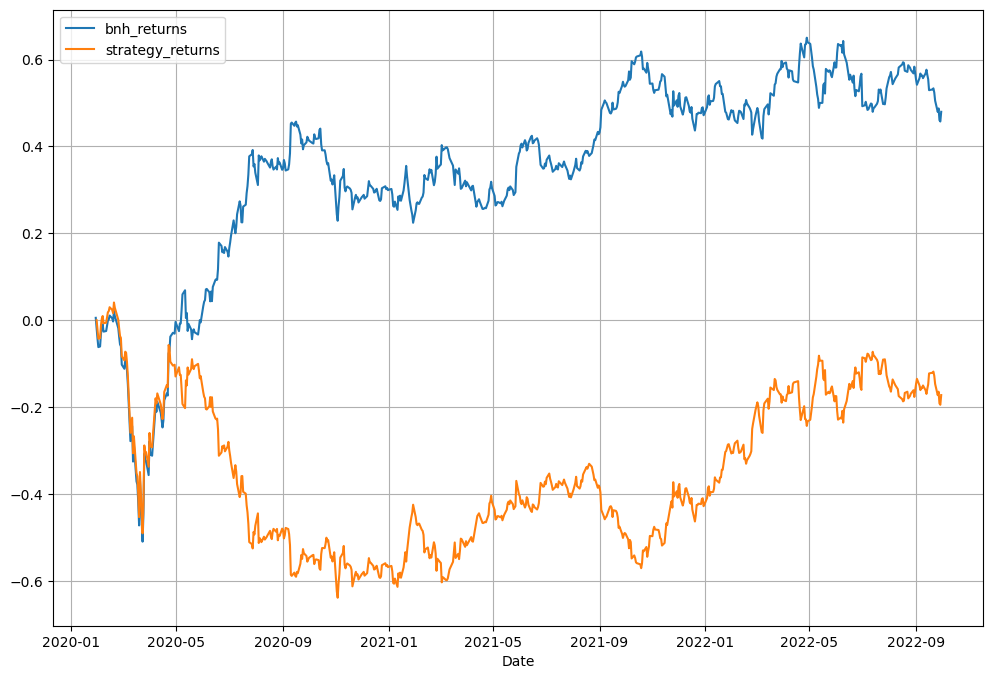

In [57]:

# comparing buy & hold strategy / bollinger bands strategy returns
print("Buy and hold returns:",df['bnh_returns'].cumsum()[-1])
print("Strategy returns:",df['strategy_returns'].cumsum()[-1])

# plotting strategy historical performance over time
df[['bnh_returns','strategy_returns']] = df[['bnh_returns','strategy_returns']].cumsum()
df[['bnh_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))

In [58]:
df.dropna(inplace = True)


In [59]:
df.index = pd.to_datetime(df.index)

In [60]:
df['strategy_returns'].diff()

Date
2020-01-30         NaN
2020-01-31   -0.022485
2020-02-01   -0.020251
2020-02-03    0.001553
2020-02-04    0.029093
                ...   
2022-09-26   -0.025807
2022-09-27    0.007919
2022-09-28   -0.026986
2022-09-29   -0.003070
2022-09-30    0.022306
Name: strategy_returns, Length: 665, dtype: float64

Start date,2020-01-30
End date,2022-09-30
Total months,31
,Backtest
Annual return,-12.2%
Cumulative returns,-29.0%
Annual volatility,35.8%
Sharpe ratio,-0.18
Calmar ratio,-0.22
Stability,0.00
Max drawdown,-54.1%


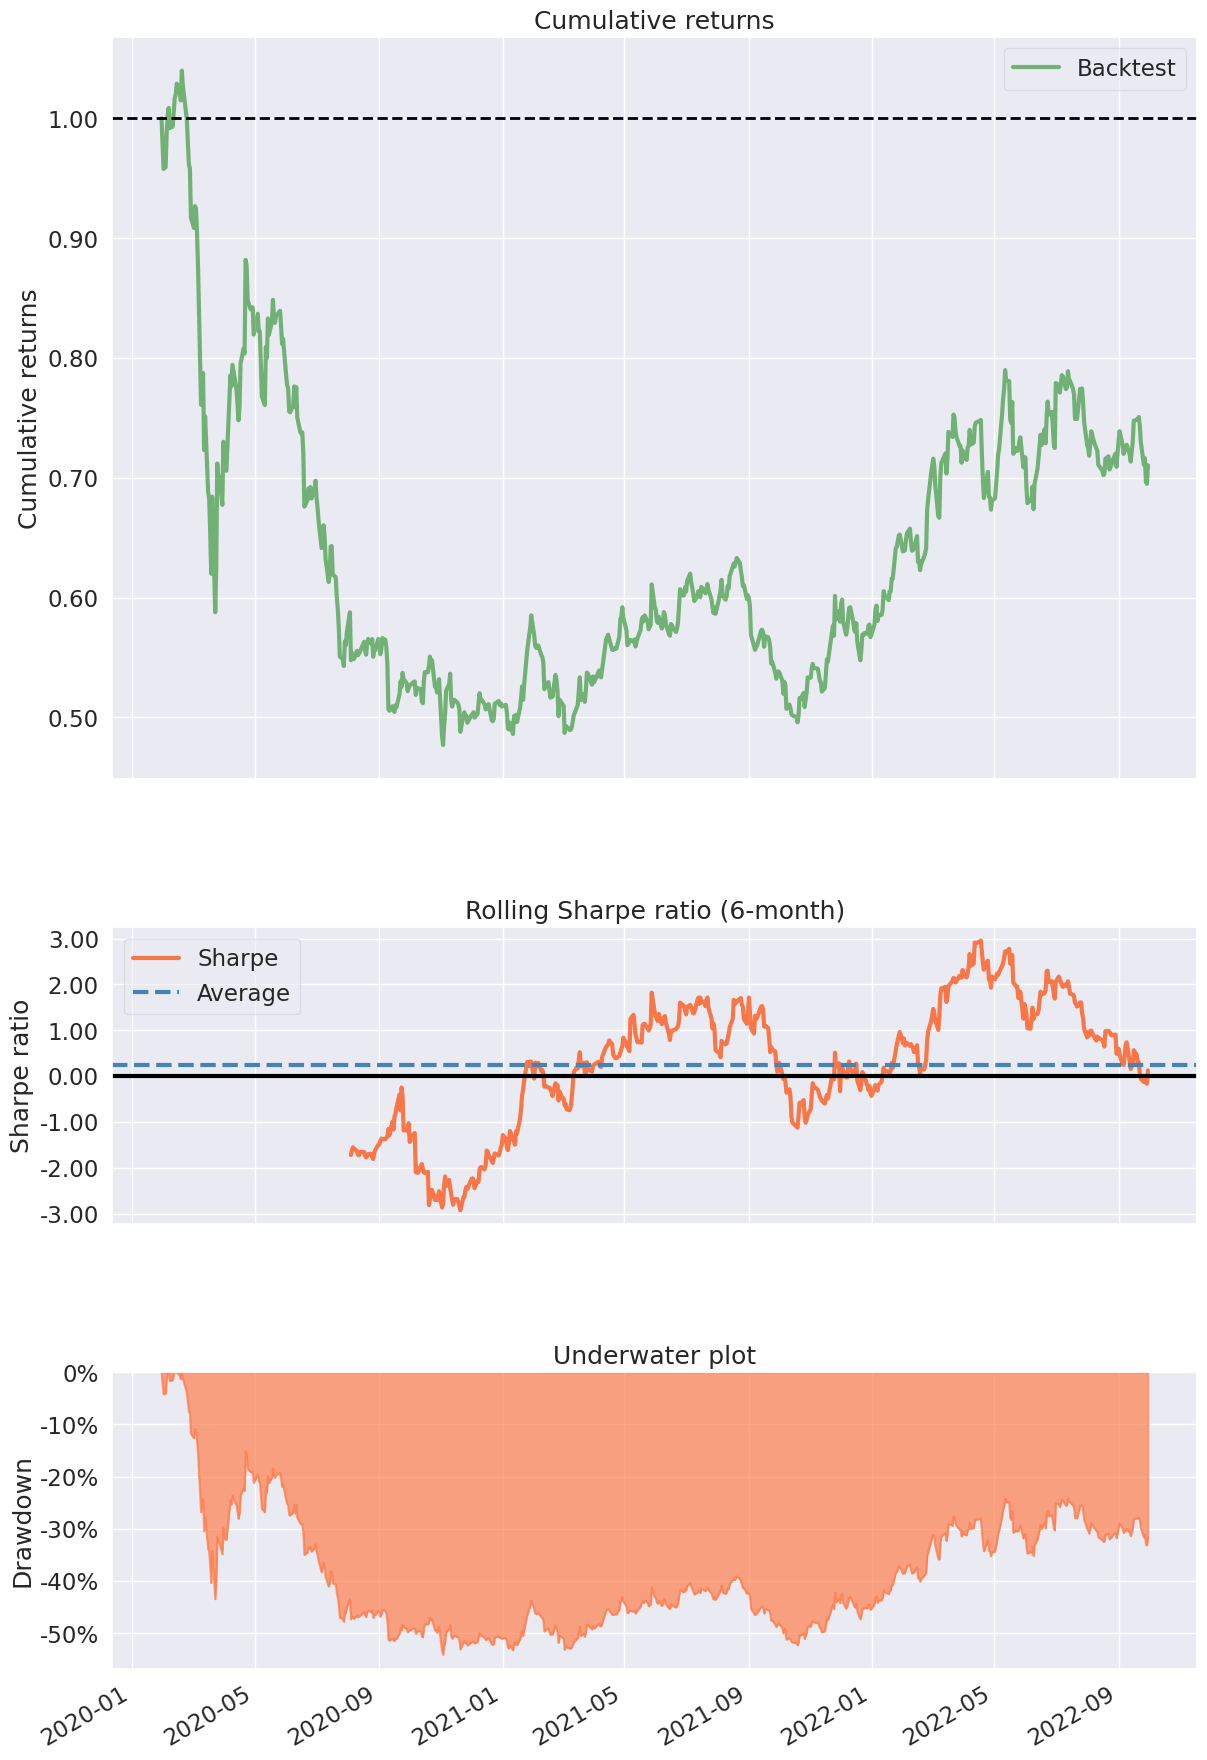

In [61]:
pf.create_simple_tear_sheet(df['strategy_returns'].diff())